In [1]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import mixedlm
from scipy.stats import rankdata
from statsmodels.stats.multitest import multipletests
import random
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform
import warnings
from skbio.stats.composition import clr

In [2]:
%pwd

'/Users/zkarwowska/new_embl_folder/zeevi_dataset_v5'

In [43]:
counts = pd.read_csv('real_datasets/palleja_dataset/ready_palleja_counts.csv', index_col=[0])
predictions = pd.read_csv('real_datasets/palleja_predictions.csv', index_col=[0])

metadata = pd.read_csv('real_datasets/palleja_dataset/ready_palleja_metadata.csv', index_col=[0]).query("Timepoint in [0, 4]")

counts = counts[metadata.Sample_ID].T

timepoint_dict = dict(zip(metadata.Sample_ID, metadata.Timepoint))
counts.index = counts.reset_index()['index'].map(timepoint_dict)

In [95]:
# Sample A and B (compositions)
counts_A = np.array([1, 1, 1]) 
counts_B = np.array([4, 1, 1])  

# Add pseudocount
pseudo = 1e-3
logFC_raw = np.log2(sample_B + pseudo) - np.log2(sample_A + pseudo)
logFC_raw

array([-1.98924694, -0.99855947, -1.99460674])

In [96]:
clr_A = clr(sample_A+pseudo)
clr_B = clr(sample_B+pseudo)

clr_logFC = clr_B - clr_A
clr_logFC

array([-0.22765903,  0.4590332 , -0.23137416])

/Users/zkarwowska/anaconda3/envs/skbio_env/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


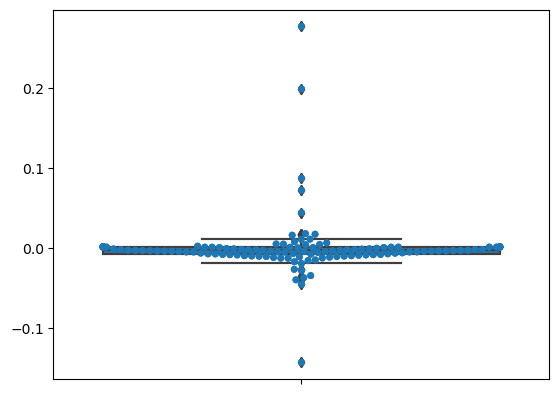

In [65]:
clr_df = pd.DataFrame(clr(counts+1), index = counts.index)
counts_mean_df = clr_df.groupby(by = ['index']).mean()

x = (counts_mean_df.loc[4] - counts_mean_df.loc[0]).values

sns.boxplot(y = x)
sns.swarmplot(y = x)
plt.show()

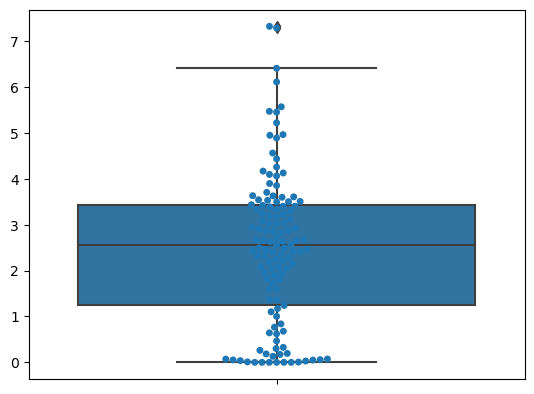

In [20]:
counts_mean_df = counts.groupby(by = ['index']).mean()+1e-3
logFC = (np.abs(
    np.log2(
        counts_mean_df.loc[0]/counts_mean_df.loc[4]
    )
)
        )

sns.boxplot(y = logFC.values)
sns.swarmplot(y = logFC.values)

plt.show()

In [77]:
counts = pd.read_csv('real_datasets/mesnage_dataset/ready_mesnage_counts.csv', index_col=[0])
predictions = pd.read_csv('real_datasets/mesnage_predictions.csv', index_col=[0])
metadata = pd.read_csv('real_datasets/mesnage_dataset/ready_mesnage_metadata.csv', index_col=[0])

counts = counts[metadata.Sample_ID].T

timepoint_dict = dict(zip(metadata.Sample_ID, metadata.Timepoint))
counts.index = counts.reset_index()['index'].map(timepoint_dict)


In [21]:
mean_df = np.log(counts+1e-3).mean().reset_index().rename({'index':'feature', 0:'mean'}, axis=1).set_index('feature')
#df = pd.concat([predictions_linda[['Timepoint.pvalue']], mean_df], axis=1)

mean_df['linda_selected'] = np.where(mean_df.index.isin(predictions['linda'].dropna().tolist()), 1, 0)
mean_df['maaslin_selected'] = np.where(mean_df.index.isin(predictions['maaslin'].dropna().tolist()), 1, 0)
mean_df['zigmm_selected'] = np.where(mean_df.index.isin(predictions['zigmm'].dropna().tolist()), 1, 0)

In [22]:
mean_stacked_df = mean_df.set_index(['mean']).stack().reset_index().rename({"level_1":"model", 0:"prediction"}, axis=1)

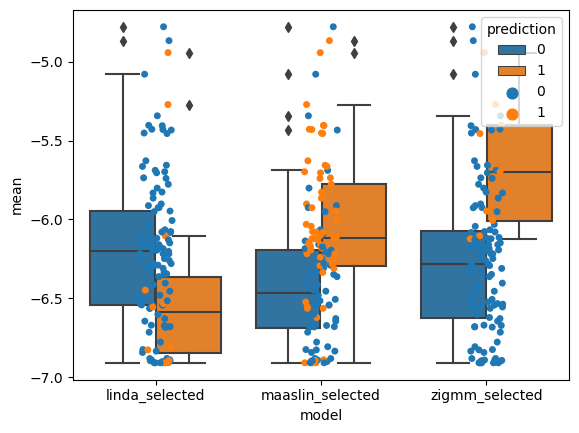

In [23]:
sns.boxplot(x=mean_stacked_df.model, y = mean_stacked_df['mean'], hue =  mean_stacked_df.prediction)
sns.stripplot(x=mean_stacked_df.model, y = mean_stacked_df['mean'], hue =  mean_stacked_df.prediction)

plt.show()

In [24]:
from scipy import stats

group1 = mean_stacked_df.query("model == 'linda_selected' and prediction==0")['mean']
group2 = mean_stacked_df.query("model == 'linda_selected' and prediction==1")['mean']


np.round(stats.ttest_ind(group1, group2)[1], 3)

0.191

In [25]:
group1 = mean_stacked_df.query("model == 'maaslin_selected' and prediction==0")['mean']
group2 = mean_stacked_df.query("model == 'maaslin_selected' and prediction==1")['mean']

np.round(stats.ttest_ind(group1, group2)[1], 3)

0.0

In [26]:
group1 = mean_stacked_df.query("model == 'zigmm_selected' and prediction==0")['mean']
group2 = mean_stacked_df.query("model == 'zigmm_selected' and prediction==1")['mean']

np.round(stats.ttest_ind(group1, group2)[1], 3)

0.0